## Deep Neural Network for Anomaly Detection in IoT Data
### By Lara Suzuki / Vint Cerf - IPNSIG

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/lasuzuki"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [118]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime
import seaborn as sns
from google.cloud import bigquery
import math

In [119]:
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [120]:
PROJECT_ID = "your-project-id"
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
GOOGLE_APPLICATION_CREDENTIALS = "your-credential.json"
BUCKET_NAME = "gs://your-bucket"
REGION = "your-region"

### Selecting real time data persisted in BigQuery

In [121]:
bqclient = bigquery.Client()
query_string = """
SELECT 
    ts, 
    temperature, 
    pressure, 
    humidity, 
    x, y, z, 
    CASE 
        WHEN label = 'True' 
        THEN 1 
        ELSE 0 
    END AS label
FROM `your-project.your_database.your_table`
WHERE label IS NOT NULL
"""
df_iot = (
    bqclient.query(query_string)
    .result()
    .to_dataframe()
)

### Splitting data into train and test sets

In [122]:
def sample_first_prows(data, perc=0.8):
    import pandas as pd
    return data.head(int(len(data)*(perc)))

df_train = sample_first_prows(df_iot)
df_test = df_iot.iloc[max(df_train.index):]

### Normalising the values

In [123]:
df_train_timestamp = df_train["ts"]
df_train_label = df_train["label"]
df_train_clear = df_train.drop(['ts', 'label'], axis=1)
df_train_mean = df_train_clear.mean()
df_train_std = df_train_clear.std()
df_train_norm = (df_train_clear - df_train_mean)/df_train_std
df_train_result = pd.concat([df_train_norm, df_train_label], axis=1)

df_test_timestamp = df_test["ts"]
df_test_label = df_test["label"]
df_test_clear = df_test.drop(['ts', 'label'], axis=1)
df_test_mean = df_test_clear.mean()
df_test_std = df_test_clear.std()
df_test_norm = (df_test_clear - df_test_mean)/df_test_std
df_test_result = pd.concat([df_test_norm, df_test_label], axis=1)

### Represent data in a feature layer

In [124]:
feature_columns = []
temperature = tf.feature_column.numeric_column("temperature")
feature_columns.append(temperature)
pressure = tf.feature_column.numeric_column("pressure")
feature_columns.append(pressure)
humidity = tf.feature_column.numeric_column("humidity")
feature_columns.append(humidity)
x = tf.feature_column.numeric_column("x")
feature_columns.append(x)
y = tf.feature_column.numeric_column("y")
feature_columns.append(y)
z = tf.feature_column.numeric_column("z")
feature_columns.append(z)
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

### Build a deep neural network model

#### Define the plotting loss curve function

In [125]:
def plot_the_loss_curve(epochs, mse):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max() * 1.03])
    plt.show()

#### Define the plotting the model function

In [126]:
def plot_curve(epochs, hist, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist.history[m]
    plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()

#### Define the deep neural network model creation function

In [163]:
def create_model(learning_rate, feature_layer):
    model = tf.keras.models.Sequential()
    model.add(feature_layer)
    model.add(tf.keras.layers.Dense(units = 10,
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                    name='Hidden1'
                                    ))
    
    model.add(tf.keras.layers.Dropout(rate=0.15))
              
    model.add(tf.keras.layers.Dense(units = 5,
                                    activation='relu',
                                    name='Hidden2'
                                    ))
              
    model.add(tf.keras.layers.Dense(units = 1,
                                    activation='relu',
                                    name='Output'
                                    ))
              
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.MeanSquaredError(), 'accuracy']
                )
              
    return model

#### Define the deep neural network model training function

In [164]:
def train_model(model, dataset, epochs, label_name, batch_size=None):
        features = {name:np.array(value) for name, value in dataset.items()}
        label = np.array(features.pop(label_name))
        history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=True)
        epochs = history.epoch
        hist = pd.DataFrame(history.history)
        mse = hist["mean_squared_error"]
        return epochs, mse, history

#### Call the functions to build and train a deep neural network

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
135/135 [==============================] - 1s 5ms/step - loss: 0.5126 - mean_squared_error: 0.4400 - accuracy: 0.4758
Epoch 2/20
135/135 [==============================] - 1s 6ms/step - loss: 0.2190 - mean_squared_error: 0.1579 - accuracy: 0.7759
Epoch 3/20
135/135 [==============================] - 1s 6ms/step - loss: 0.1497 - mean_squared_error: 0.0971 - accuracy: 0.8928
Epoch 4/20
135/135 [==============================] - 0s 3ms/step - loss: 0.1233 - mean_squared_error: 0.0775 - accuracy: 0.9322
Epoch 5/20
135/135 [==============================] - 1s 5ms/step - loss: 0.0995 - mean_squared_error: 0.0598 - accuracy: 0.9404
Epoch 6/20
135/135 [==============================] - 1s 4ms/step - loss: 0.0783 - mean_squared_error: 0.0436 - accuracy: 0.9464
Epoch 7/20
135/135 [==============================] - 1s 6ms/step - loss: 0.0724 - mean_squared_error: 0.0421 - accu

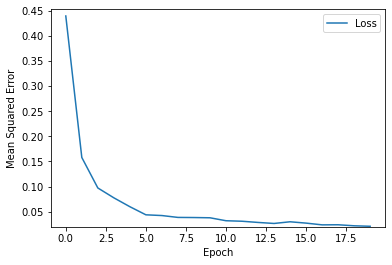

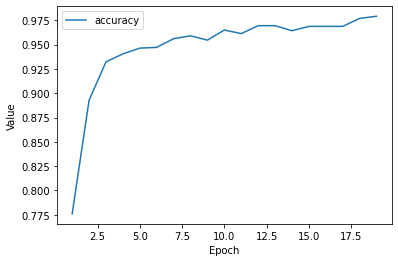

In [165]:
learning_rate = 0.001
epochs = 20
batch_size = 10
label_name = "label"
model = create_model(learning_rate, feature_layer)
epochs, mse, hist = train_model(model, df_train_result, epochs, label_name, batch_size)
plot_the_loss_curve(epochs, mse)
list_of_metrics_to_plot = ['accuracy'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

#### Call the functions to test the deep neural network

In [166]:
test_features = {name:np.array(value) for name, value in df_test_result.items()}
test_label = np.array(test_features.pop(label_name))
results = model.evaluate(x=test_features, y=test_label, batch_size=batch_size)
print(results)
predict = model.predict(test_features)
print_predict = predict[:10]
for i, val in enumerate(print_predict):
    print('Predicted output: {}'.format(math.floor(val[0])))
    print('Actual output: {} \n'.format(test_label[i]))

Consider rewriting this model with the Functional API.
34/34 [==============================] - 0s 4ms/step - loss: 0.7535 - mean_squared_error: 0.7450 - accuracy: 0.0000e+00
[0.7535382509231567, 0.7449658513069153, 0.0]
Consider rewriting this model with the Functional API.
Predicted output: 0
Actual output: 0 

Predicted output: 0
Actual output: 0 

Predicted output: 0
Actual output: 0 

Predicted output: 0
Actual output: 0 

Predicted output: 0
Actual output: 0 

Predicted output: 0
Actual output: 0 

Predicted output: 0
Actual output: 0 

Predicted output: 0
Actual output: 0 

Predicted output: 0
Actual output: 0 

Predicted output: 0
Actual output: 0 

